In [3]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [4]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [5]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [6]:
mag_abund_frame = data.frame(fread("../../data/mag_abund_res_90perc_top20.csv"))
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))
metadata_file["SampleDate"] = "1900-01-01"
for (curr in 1:nrow(metadata_file)) {
    curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]

    if (grepl("ME", curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-ME"))
        curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        sample_date = curr_token
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "D"))
        sample_date = listed_meta[1]
        curr_token = sample_date
        if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } 
    } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
        listed_meta = unlist(strsplit(curr_token, "s"))
        sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
    } else if (!is.na(curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-"))
        sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
    } else {
        sample_date = ""
    }

    if (grepl("Fre",sample_date)) {
        sample_date = "Control"
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        sample_date = unlist(strsplit(sample_date,"D"))[1]

        if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

            sample_date = unlist(strsplit(sample_date, "s"))[1]
        }
        metadata_file$SampleDate[curr] = sample_date
    } else {
        metadata_file$SampleDate[curr] = sample_date
    }


}
mag_abund_frame = mag_abund_frame %>%
    dplyr::left_join(metadata_file)

Joining, by =
"SeqProjID"


In [7]:
for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"
for_plotting = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

In [8]:
t_test_2010 <- function(for_plotting, label, test = "ks", alternative="greater", thres_year = 2010) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(t.test(pre_2010$TPM, post_2010$TPM,alternative=alternative))
    }
}
categorize_vals = data.frame()
for_plot_tax = for_plotting %>% dplyr::distinct(Phylum,Order,Class,Genus,Family,Label)
for (curr_ind in c(1:nrow(for_plot_tax))) {
    curr = for_plot_tax$Label[curr_ind]
    curr_pval = t_test_2010(for_plotting, curr, test = "t", alternative="less", thres_year = 2010)$p.value
    if (curr_pval <= 0.05) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="IncreasedPost2010")
    } else if (curr_pval >= 0.95) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="DecreasedPost2010")
    } else {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval, "Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="NoChange")
    }
    categorize_vals = categorize_vals %>% dplyr::bind_rows(curr_df)
}
categorize_vals$Verdict[p.adjust(categorize_vals$p.value, "BH") <= 0.05] = "IncreasedPost2010"
categorize_vals$Verdict[p.adjust(1-categorize_vals$p.value, "BH") <= 0.05] = "DecreasedPost2010"
categorize_vals$Verdict[(p.adjust(1-categorize_vals$p.value, "BH") > 0.05) &
                        (p.adjust(categorize_vals$p.value, "BH") > 0.05)] = "NoChange"

`summarise()` has
grouped output by
'YearCat', 'Label'.
You can override
using the `.groups`
argument.
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


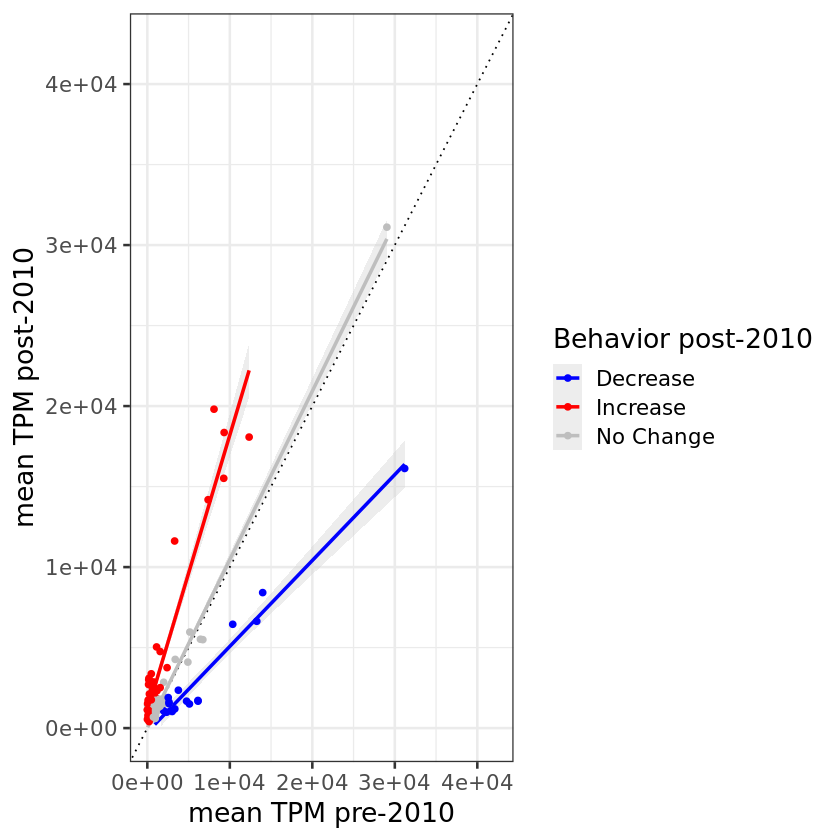

In [9]:
tpm_change_plot = ggplot(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label")) %>%
       dplyr::mutate(YearCat = dplyr::case_when(Year < 2010 ~ "pre2010",
                                                Year >= 2010 ~ "post2010")) %>%
       dplyr::group_by(YearCat,Label,Verdict) %>% dplyr::summarize(meanZScore = mean(TPM),
                                                           sdZScore = sd(ZScore)) %>%
       pivot_wider(id_cols = c(Label,Verdict), names_from = YearCat, values_from = meanZScore))  + 
    geom_abline(intercept=0,slope=1,linetype="dotted")+ 
    geom_smooth(aes(x = pre2010, y = post2010, color = Verdict,group = Verdict),
                method="lm",fill="lightgray")+
    geom_point(aes(x = pre2010, y = post2010, color = Verdict))+ theme_bw(base_size=16) + 
    #theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    scale_color_manual(values = c("blue","red", "grey"),
                      breaks = c("DecreasedPost2010",
                                 "IncreasedPost2010",
                                 "NoChange"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") + 
    scale_y_continuous(labels = function(x) format(x, scientific = TRUE),
                       limits = c(min(for_plotting$TPM),max(for_plotting$TPM)/10))+ 
    scale_x_continuous(labels = function(x) format(x, scientific = TRUE),
                       limits = c(min(for_plotting$TPM),max(for_plotting$TPM)/10)) + 
    ylab("mean TPM post-2010") + xlab("mean TPM pre-2010")
#+ facet_wrap(~Label)
tpm_change_plot

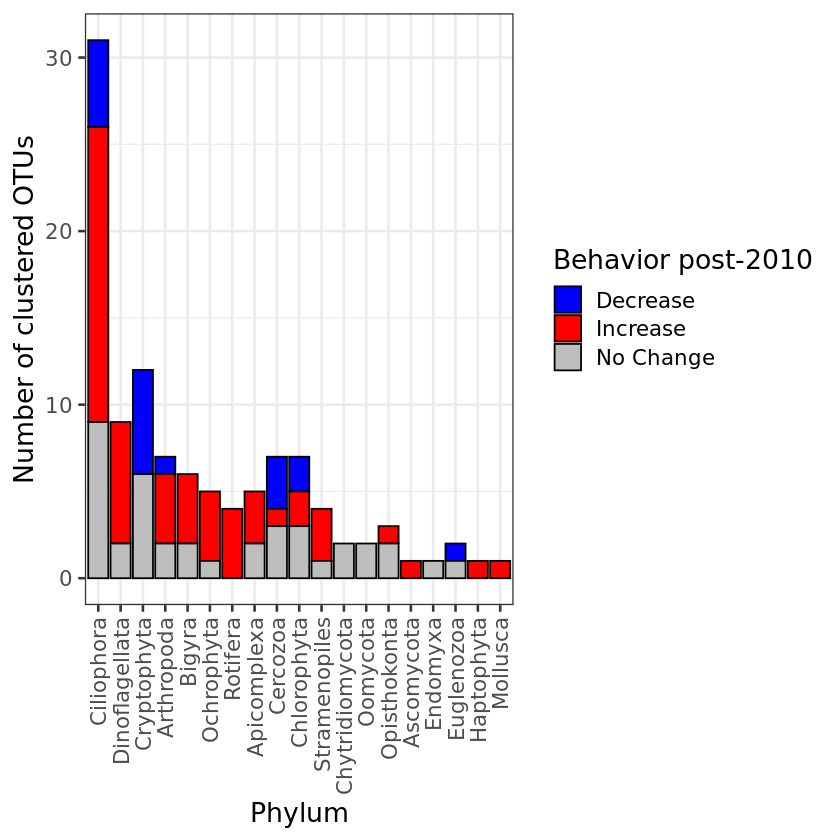

In [10]:
tallied_vals = categorize_vals %>% dplyr::group_by(Phylum,Verdict) %>% dplyr::tally() %>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum=="Alveolata" ~ "Dinoflagellata",
                                           TRUE ~Phylum))
sorted_phyla = unique((tallied_vals %>% dplyr::arrange(desc(n)))$Phylum)
behavior_post_2010 = ggplot(tallied_vals)+
    geom_bar(aes(x = factor(Phylum,levels=sorted_phyla), y = n, fill = Verdict), stat = "identity", 
             position = "stack", color = "black")+ theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    scale_fill_manual(values = c("blue","red", "grey"),
                      breaks = c("DecreasedPost2010",
                                 "IncreasedPost2010",
                                 "NoChange"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") + 
    ylab("Number of clustered OTUs") + xlab("Phylum")
behavior_post_2010

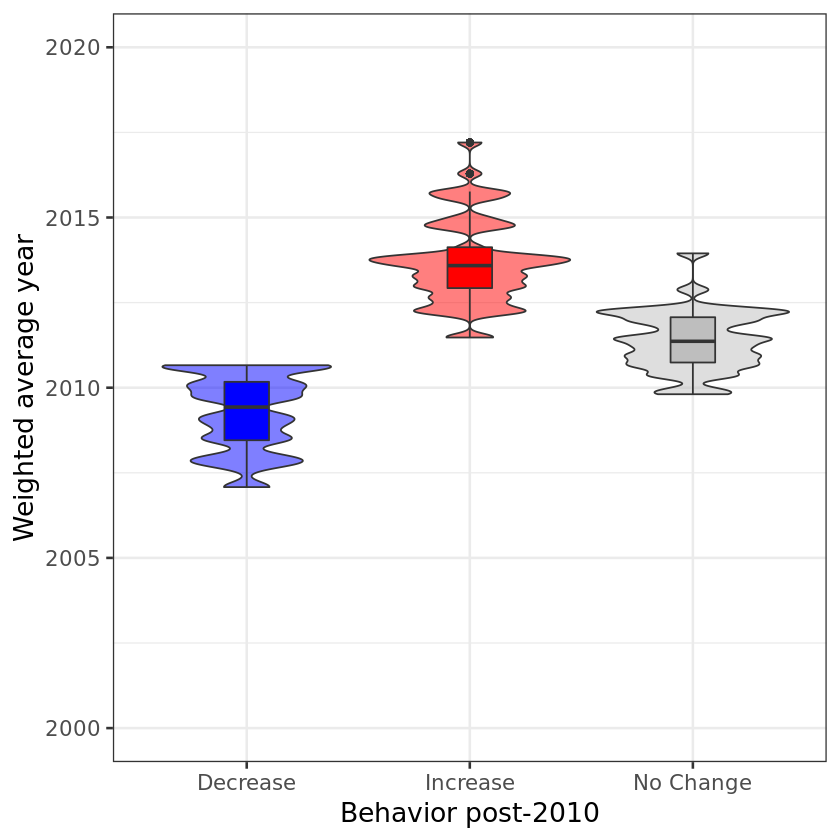

In [11]:
verdict_post_2010 = ggplot(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label")) %>%
    dplyr::group_by(Label,Verdict) %>%
    dplyr::filter(!is.na(Year)) %>%
    dplyr::mutate(WeightedYear = sum(TPM * Year,na.rm=TRUE) / sum(TPM,na.rm=TRUE)) %>%
    dplyr::mutate(Verdict = dplyr::case_when(Verdict == "NoChange" ~ "No Change",
                                             Verdict == "IncreasedPost2010" ~ "Increase",
                                             Verdict == "DecreasedPost2010" ~ "Decrease"))) + 
    geom_violin(aes(x = Verdict, y = WeightedYear,fill=Verdict), alpha = 0.5) + 
    geom_boxplot(aes(x = Verdict, y = WeightedYear,fill=Verdict), width=0.2) + ylim(c(2000,2020)) + 
    scale_fill_manual(values = c("blue","red", "grey"),
                      breaks = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") +
    theme_bw(base_size=16) + ylab("Weighted average year") + xlab("Behavior post-2010") + 
    theme(legend.position="none")
verdict_post_2010

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


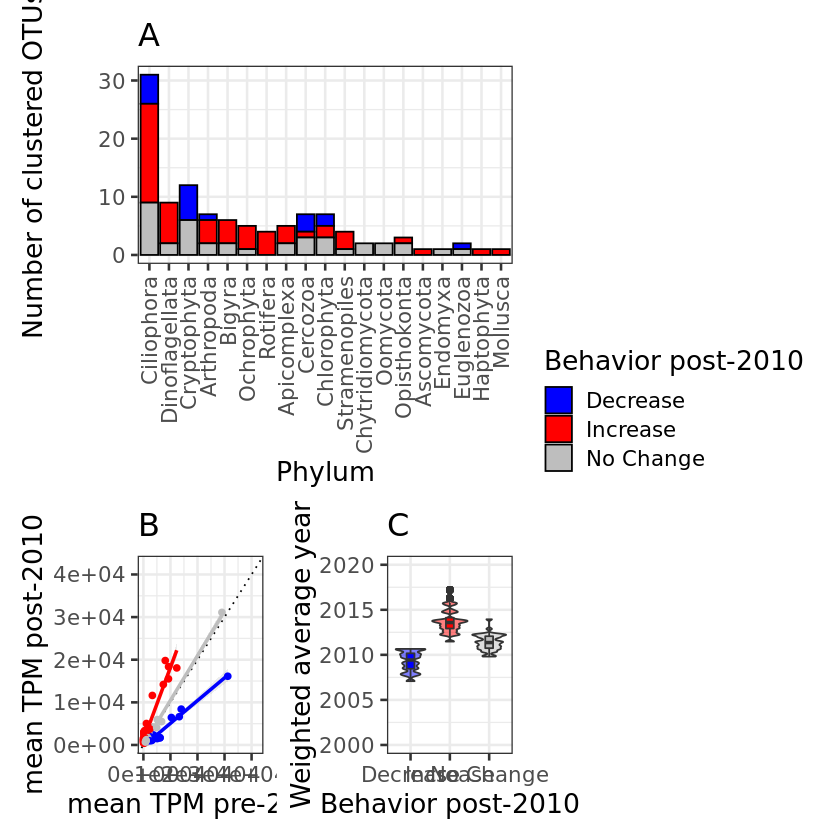

In [12]:
(behavior_post_2010 + ggtitle("A")) / ((tpm_change_plot + theme(legend.position="none") + ggtitle("B")) + 
 (verdict_post_2010 + ggtitle("C"))) +
  plot_layout(guides = 'collect')
ggsave(file = "../../figures/facetted_increase_plot.png", dpi = 400, width=12,height=10, units="in")
ggsave(file = "../../figures/facetted_increase_plot.pdf", dpi = 400, width=12,height=10, units="in")